In [3]:
import warnings

In [4]:
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np

# Step 1: Data Preprocessing
# Load dataset
df = pd.read_csv('updated_dataset.csv')
df

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EA0K,Thurston,Tumwater,WA,98512.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,42490.0,22.0,242565116,POINT (-122.91310169999997 47.01359260000004),PUGET SOUND ENERGY INC,5.306701e+10
1,1N4BZ1DV4N,Island,Clinton,WA,98236.0,2022,NISSAN,LEAF,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,28495.0,10.0,183272785,POINT (-122.35936399999997 47.97965520000008),PUGET SOUND ENERGY INC,5.302997e+10
2,5YJ3E1EA0L,Snohomish,Snohomish,WA,98290.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266.0,42490.0,44.0,112552366,POINT (-122.09150499999998 47.91555500000004),PUGET SOUND ENERGY INC,5.306105e+10
3,5YJ3E1EBXL,King,Seattle,WA,98134.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322.0,42490.0,11.0,6336319,POINT (-122.32981499999994 47.579810000000066),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
4,5YJSA1CP0D,Snohomish,Edmonds,WA,98020.0,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208.0,69900.0,21.0,186212960,POINT (-122.37507 47.80807000000004),PUGET SOUND ENERGY INC,5.306105e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119172,5YJSA1E29L,King,Yarrow Point,WA,98004.0,2020,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,330.0,92000.0,48.0,124776627,POINT (-122.20190499999995 47.61385000000007),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
119173,5YJYGDEE7M,King,Burien,WA,98168.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,44990.0,33.0,142857676,POINT (-122.28645999999998 47.47613000000007),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303303e+10
119174,5YJSA1E51N,Pierce,Gig Harbor,WA,98335.0,2022,TESLA,MODEL S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,92000.0,26.0,220157724,POINT (-122.58354539999999 47.32344880000005),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,5.305307e+10
119175,KM8KMDAF3P,Grant,Ephrata,WA,98823.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,41000.0,13.0,223872596,POINT (-119.55512999999996 47.319360000000074),PUD NO 2 OF GRANT COUNTY,5.302501e+10


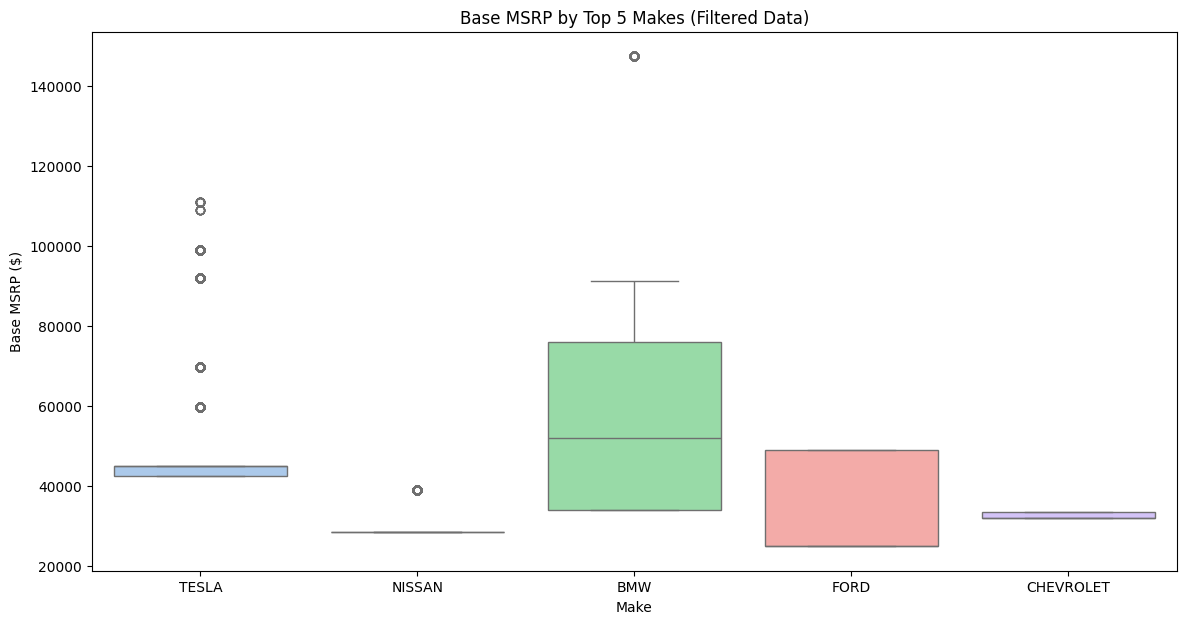

In [6]:
top_5_makes = df['Make'].value_counts().nlargest(5).index
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[df['Make'].isin(top_5_makes)], x='Make', y='Base MSRP', palette='pastel')
plt.title('Base MSRP by Top 5 Makes (Filtered Data)')
plt.xlabel('Make')
plt.ylabel('Base MSRP ($)')
plt.show()

In [7]:
# Drop irrelevant columns
columns_to_drop = ['VIN (1-10)', 'Vehicle Location', 'DOL Vehicle ID', '2020 Census Tract','Postal Code']
df_cleaned = df.drop(columns=columns_to_drop)

# Handle missing values
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
print("categorical_cols ", categorical_cols)
print("numerical_cols ", numerical_cols)
df.isnull().sum()

# Drop rows with missing values and count how many rows are dropped
initial_row_count = df_cleaned.shape[0]
df_cleaned = df_cleaned.dropna()
final_row_count = df_cleaned.shape[0]
rows_dropped = initial_row_count - final_row_count

print(f"Initial number of rows: {initial_row_count}")
print(f"Final number of rows after dropping missing values: {final_row_count}")
print(f"Number of rows dropped due to missing values: {rows_dropped}")

categorical_cols  Index(['County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
       'Electric Utility'],
      dtype='object')
numerical_cols  Index(['Model Year', 'Electric Range', 'Base MSRP', 'Legislative District'], dtype='object')
Initial number of rows: 119177
Final number of rows after dropping missing values: 118917
Number of rows dropped due to missing values: 260


In [8]:
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'Clean Alternative Fuel Vehicle (CAFV) Eligibility':
        le = LabelEncoder()
        df_cleaned[col] = le.fit_transform(df_cleaned[col])
        label_encoders[col] = le

# Encode target column
target_encoder = LabelEncoder()
df_cleaned['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = target_encoder.fit_transform(
    df_cleaned['Clean Alternative Fuel Vehicle (CAFV) Eligibility']
)
df_cleaned

,County,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,Electric Utility
0,33,400,0,2019,22,36,0,0,220.0,42490.0,22.0,71
1,14,69,0,2022,17,35,0,1,0.0,28495.0,10.0,71
2,30,357,0,2020,22,36,0,0,266.0,42490.0,44.0,71
3,16,340,0,2020,22,36,0,0,322.0,42490.0,11.0,56
4,30,109,0,2013,22,37,0,0,208.0,69900.0,21.0,71
...,...,...,...,...,...,...,...,...,...,...,...,...
119172,16,440,0,2020,22,37,0,0,330.0,92000.0,48.0,72
119173,16,42,0,2021,22,39,0,1,0.0,44990.0,33.0,56
119174,26,139,0,2022,22,37,0,1,0.0,92000.0,26.0,19
119175,12,119,0,2023,10,30,0,1,0.0,41000.0,13.0,70


In [9]:
X = df_cleaned.drop(columns=['Clean Alternative Fuel Vehicle (CAFV) Eligibility'])
print(df_cleaned.corr()['Clean Alternative Fuel Vehicle (CAFV) Eligibility'])

County                                               0.007028
City                                                -0.000500
State                                                     NaN
Model Year                                           0.373821
Make                                                 0.048462
Model                                                0.018293
Electric Vehicle Type                                0.337613
Clean Alternative Fuel Vehicle (CAFV) Eligibility    1.000000
Electric Range                                      -0.708881
Base MSRP                                           -0.106936
Legislative District                                -0.020609
Electric Utility                                    -0.008436
Name: Clean Alternative Fuel Vehicle (CAFV) Eligibility, dtype: float64


In [10]:
df_cleaned.drop(columns=['State'], inplace=True)

Generating distribution plots for numerical features...


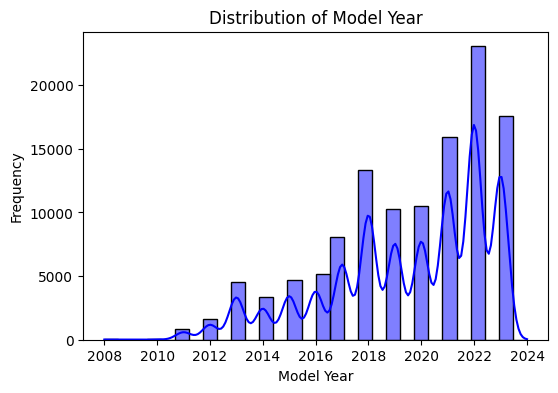

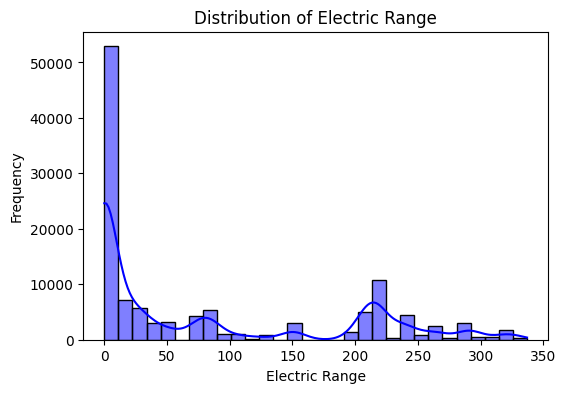

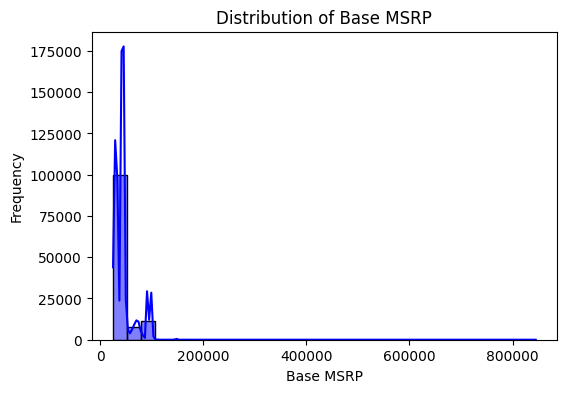

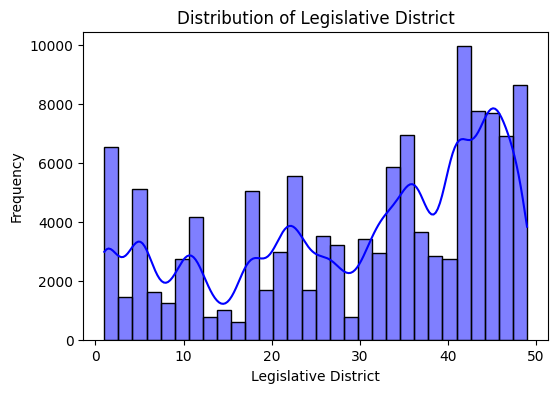

Target Variable Distribution:


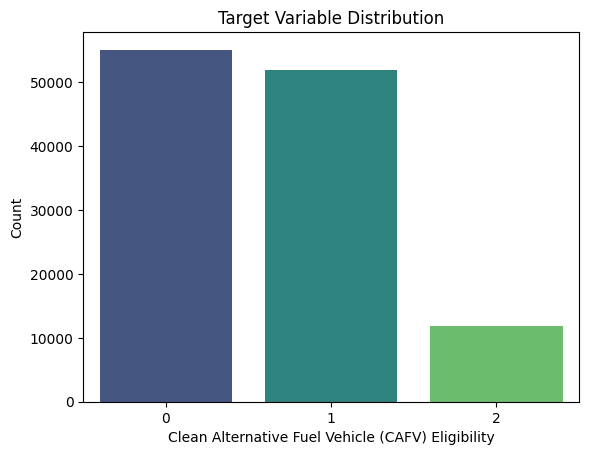

Correlation Matrix of Features:


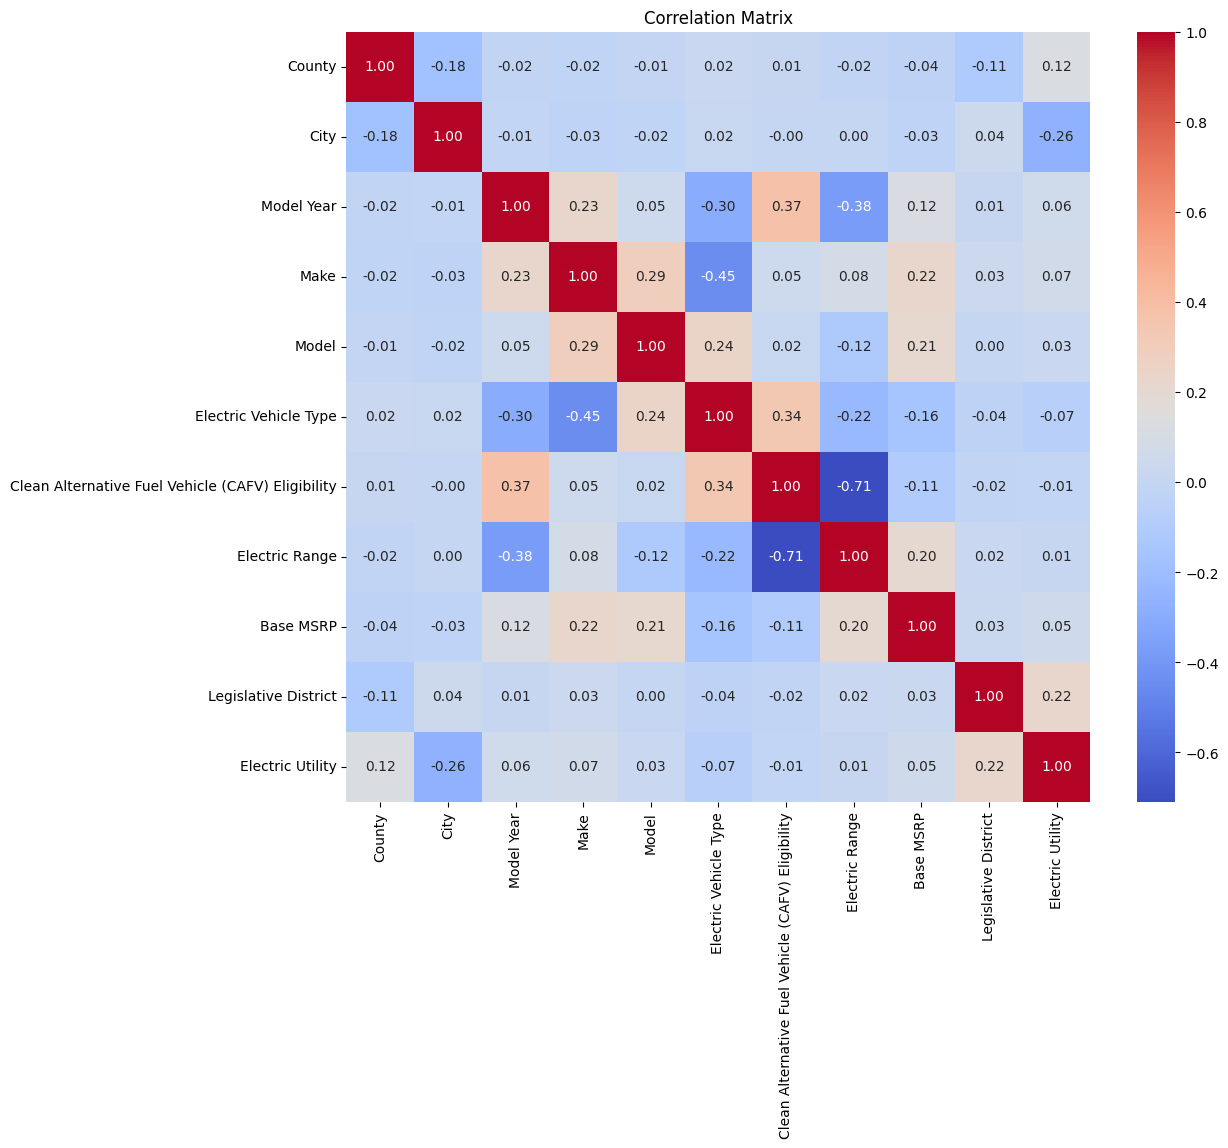

Correlation of Features with the Target Variable:
Clean Alternative Fuel Vehicle (CAFV) Eligibility    1.000000
Model Year                                           0.373821
Electric Vehicle Type                                0.337613
Make                                                 0.048462
Model                                                0.018293
County                                               0.007028
City                                                -0.000500
Electric Utility                                    -0.008436
Legislative District                                -0.020609
Base MSRP                                           -0.106936
Electric Range                                      -0.708881
Name: Clean Alternative Fuel Vehicle (CAFV) Eligibility, dtype: float64


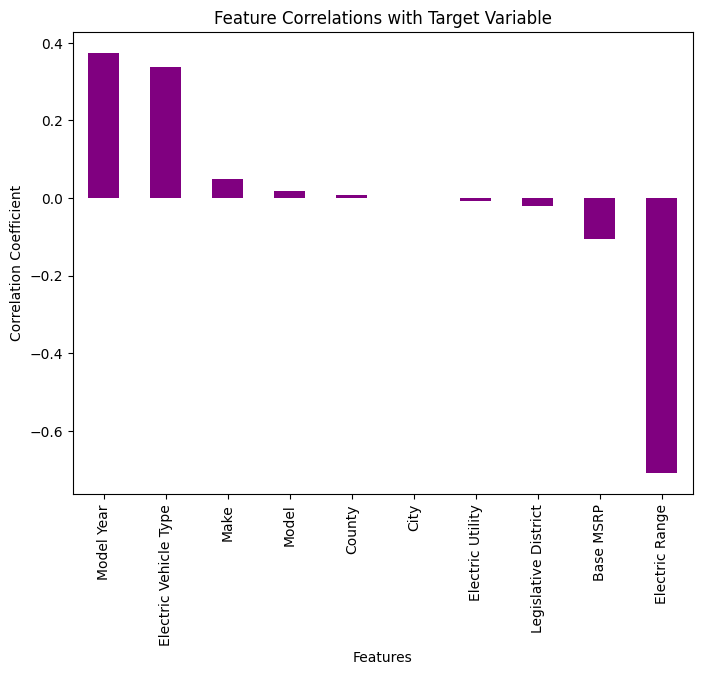

In [11]:
# Exploratory Data Analysis (EDA)
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution plots of each feature
print("Generating distribution plots for numerical features...")
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_cleaned[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Target variable distribution
print("Target Variable Distribution:")
y = df_cleaned['Clean Alternative Fuel Vehicle (CAFV) Eligibility']
sns.countplot(x=y, palette='viridis')
plt.title("Target Variable Distribution")
plt.xlabel("Clean Alternative Fuel Vehicle (CAFV) Eligibility")
plt.ylabel("Count")
plt.show()

# Correlation matrix of features
print("Correlation Matrix of Features:")
correlation_matrix = df_cleaned.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Correlation of features with the target variable
print("Correlation of Features with the Target Variable:")
target_corr = df_cleaned.corr()['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].sort_values(ascending=False)
print(target_corr)
plt.figure(figsize=(8, 6))
target_corr.drop('Clean Alternative Fuel Vehicle (CAFV) Eligibility').plot(kind='bar', color='purple')
plt.title("Feature Correlations with Target Variable")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.show()

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Original distribution:", Counter(y))

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the resampled class distribution
print("Resampled distribution:", Counter(y_resampled))

Original distribution: Counter({0: 55103, 1: 51959, 2: 11855})
Resampled distribution: Counter({0: 55103, 1: 55103, 2: 55103})


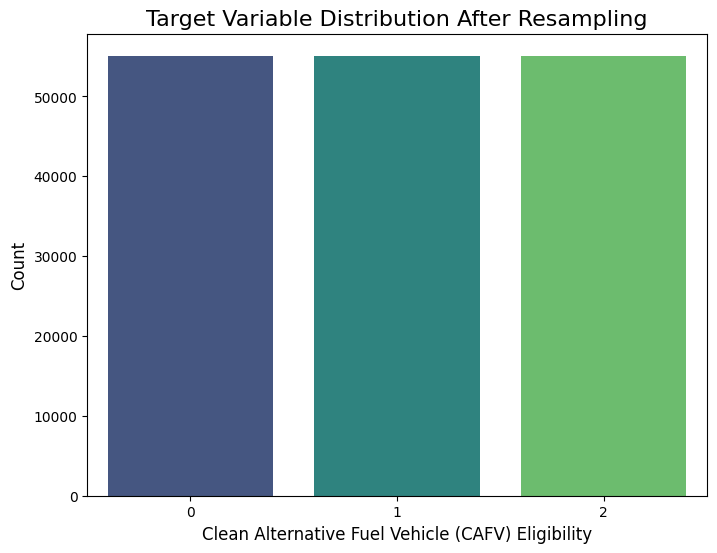

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_cleaned, x=y_resampled, palette='viridis')

# Add labels and title
plt.title('Target Variable Distribution After Resampling', fontsize=16)
plt.xlabel('Clean Alternative Fuel Vehicle (CAFV) Eligibility', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

In [14]:
# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=15)
# print("X_train ", X_train)
# print("X_test ", X_test)
# Step 4: Standardize numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Logistic Regression
log_reg = LogisticRegression(max_iter=50, random_state=25)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# # Support Vector Classifier (SVC)
# Parameter grid for SVC
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV for SVC
grid_search_svc = GridSearchCV(estimator=SVC(random_state=19, max_iter=200),
                               param_grid=param_grid_svc,
                               cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search_svc.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters for SVC:", grid_search_svc.best_params_)
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)
print("SVC Classification Report (Tuned):")
print(classification_report(y_test, y_pred_svc))


# # K-Nearest Neighbors (KNN)
# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}

# GridSearchCV for KNN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid_knn,
                               cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters for KNN:", grid_search_knn.best_params_)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
print("KNN Classification Report (Tuned):")
print(classification_report(y_test, y_pred_knn))


# Perceptron
# Parameter grid for Perceptron
param_grid_perceptron = {
    'max_iter': [100, 300, 500],
    'penalty': ['l2', 'l1', None],
    'alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV for Perceptron
grid_search_perceptron = GridSearchCV(estimator=Perceptron(random_state=30),
                                      param_grid=param_grid_perceptron,
                                      cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search_perceptron.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters for Perceptron:", grid_search_perceptron.best_params_)
best_perceptron = grid_search_perceptron.best_estimator_
y_pred_perceptron = best_perceptron.predict(X_test)
print("Perceptron Classification Report (Tuned):")
print(classification_report(y_test, y_pred_perceptron))

# Naive Bayes Classification
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     11081
           1       0.91      0.91      0.91     10997
           2       0.74      0.77      0.76     10984

    accuracy                           0.82     33062
   macro avg       0.82      0.82      0.82     33062
weighted avg       0.82      0.82      0.82     33062

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVC Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.65      0.86      0.74     11081
           1       0.96      0.66      0.78     10997
           2       0.57      0.56      0.56     10984

    accuracy                           0.69     33062
   macro avg       0.73      0.69      0.70     33062
weighted avg       0.73      0.69      0.70     33062

Fitting 5 folds for each of

In [15]:
columns_to_keep = [
    'Postal Code', 'Model Year', 'Electric Vehicle Type', 
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 
    'Electric Range', 'Base MSRP', 'Legislative District', 
    'DOL Vehicle ID', '2020 Census Tract'
]

df_new = df[columns_to_keep]

df_new

,Postal Code,Model Year,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
0,98512.0,2019,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,42490.0,22.0,242565116,5.306701e+10
1,98236.0,2022,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,28495.0,10.0,183272785,5.302997e+10
2,98290.0,2020,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266.0,42490.0,44.0,112552366,5.306105e+10
3,98134.0,2020,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322.0,42490.0,11.0,6336319,5.303301e+10
4,98020.0,2013,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208.0,69900.0,21.0,186212960,5.306105e+10
...,...,...,...,...,...,...,...,...,...
119172,98004.0,2020,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,330.0,92000.0,48.0,124776627,5.303302e+10
119173,98168.0,2021,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,44990.0,33.0,142857676,5.303303e+10
119174,98335.0,2022,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,92000.0,26.0,220157724,5.305307e+10
119175,98823.0,2023,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,41000.0,13.0,223872596,5.302501e+10


In [16]:
df_new['Electric Vehicle Type'] = df_new['Electric Vehicle Type'].replace({'Battery Electric Vehicle (BEV)':0, 'Plug-in Hybrid Electric Vehicle (PHEV)':1})

df_new['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = df_new['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].replace({'Clean Alternative Fuel Vehicle Eligible':0, 'Eligibility unknown as battery range has not been researched':1, 'Not eligible due to low battery range':2})

In [17]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['Postal Code', 'Model Year', 'Electric Range', 'Base MSRP', 
                    'Legislative District', '2020 Census Tract']

standard_scaler = StandardScaler()

df_standard_scaled = df_new.copy()

df_standard_scaled[columns_to_scale] = standard_scaler.fit_transform(df_new[columns_to_scale])

In [18]:
df_standard_scaled.dropna(axis=0,inplace=True)

In [19]:
X = df_standard_scaled.drop(columns=['Base MSRP'])
y = df_standard_scaled['Base MSRP']

In [20]:
X_train,X_test,y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

XGBoost - MSE: 0.2809446167783471, R2: 0.7107282486885074


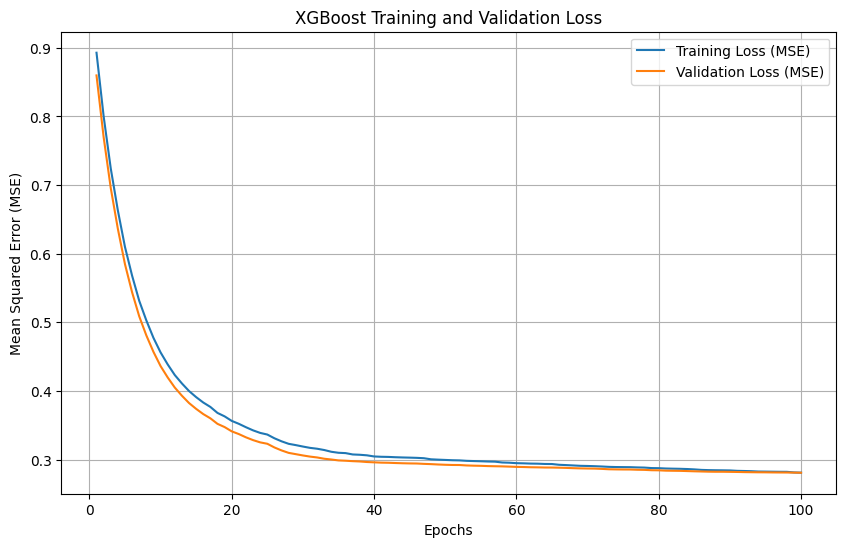

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42, 
    eval_metric="rmse"
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost - MSE: {mse}, R2: {r2}")

results = xgb.evals_result()

train_mse = [rmse**2 for rmse in results['validation_0']['rmse']]
val_mse = [rmse**2 for rmse in results['validation_1']['rmse']]

# Plot MSE for training and validation
epochs = range(1, len(train_mse) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mse, label='Training Loss (MSE)')
plt.plot(epochs, val_mse, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('XGBoost Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error (MSE): 0.2889405002652946
R-squared (R2): 0.7010644260367823


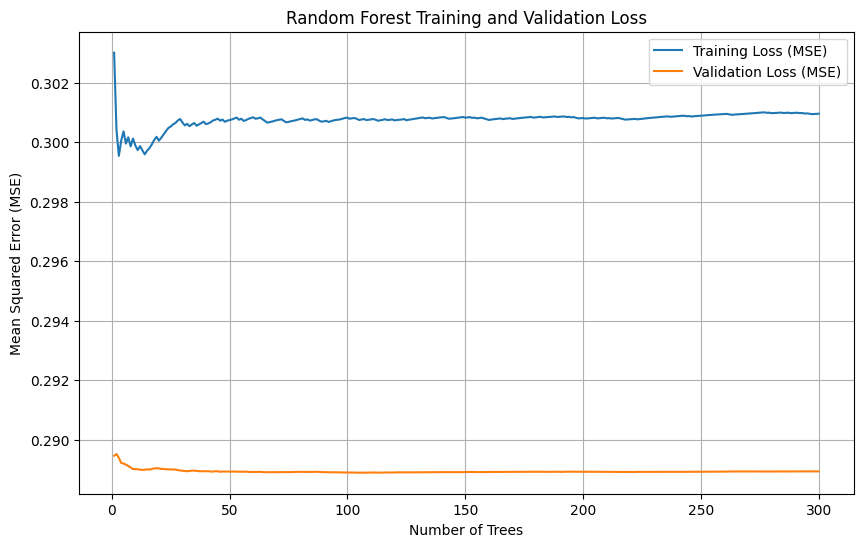

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming df_standard_scaled is your preprocessed DataFrame
# Prepare features (X) and target (y)
X = np.array(df_standard_scaled.drop(columns=['Base MSRP', 'DOL Vehicle ID', '2020 Census Tract', 'Legislative District', 'Postal Code']))
y = np.array(df_standard_scaled['Base MSRP'])  # Target variable

# Split the dataset into train, validation, and test (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize RandomForestRegressor
model = RandomForestRegressor(
    max_depth=15,
    min_samples_leaf=3,
    min_samples_split=5,
    n_estimators=300,
    random_state=42,
    oob_score=True
)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Predictions from each tree
all_tree_preds_train = np.array([tree.predict(X_train) for tree in model.estimators_])
all_tree_preds_val = np.array([tree.predict(X_test) for tree in model.estimators_])

# Lists to store losses
train_losses = []
val_losses = []

# Calculate MSE for increasing number of trees
for i in range(1, model.n_estimators + 1):
    avg_train_preds = np.mean(all_tree_preds_train[:i], axis=0)
    avg_val_preds = np.mean(all_tree_preds_val[:i], axis=0)
    train_losses.append(mean_squared_error(y_train, avg_train_preds))
    val_losses.append(mean_squared_error(y_test, avg_val_preds))

# Plotting the results with default colors (blue and orange)
epochs = range(1, model.n_estimators + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss (MSE)')
plt.plot(epochs, val_losses, label='Validation Loss (MSE)')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Random Forest Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error (MSE): 0.2885068346651568
R-squared (R2): 0.7015130930632679


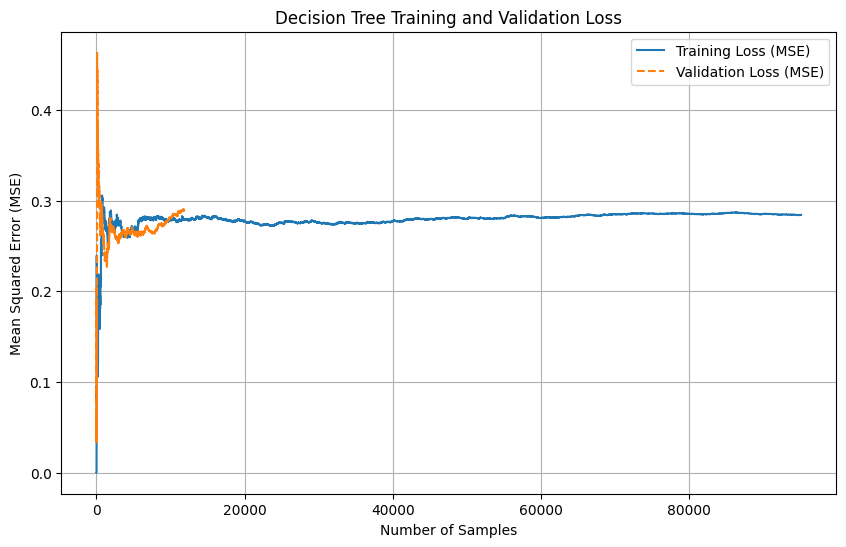

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming df_standard_scaled is your preprocessed DataFrame
# Prepare features (X) and target (y)
X = np.array(df_standard_scaled.drop(columns=['Base MSRP', 'DOL Vehicle ID', '2020 Census Tract', 'Legislative District', 'Postal Code']))
y = np.array(df_standard_scaled['Base MSRP'])  # Target variable

# Split the dataset into train, validation, and test (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=15, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Predict on the training and validation sets
train_preds = model.predict(X_train)
val_preds = model.predict(X_test)

# Calculate MSE for increasing number of samples
train_losses = [mean_squared_error(y_train[:i], train_preds[:i]) for i in range(1, len(X_train) + 1)]
val_losses = [mean_squared_error(y_test[:i], val_preds[:i]) for i in range(1, len(X_test) + 1)]

# Plotting the results with default colors (blue and orange)
epochs = range(1, len(X_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss (MSE)')
plt.plot(range(1, len(X_test) + 1), val_losses, label='Validation Loss (MSE)', linestyle='dashed')
plt.xlabel('Number of Samples')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Decision Tree Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
from IPython.display import display, HTML


data = {
    "Model": ["Logistic Regression", "SVC (Tuned)", "KNN (Tuned)", "Perceptron (Tuned)", "Naive Bayes"],
    "Precision": [0.76, 0.74, 0.99, 1.00, 0.97],
    "Recall": [0.72, 0.71, 0.99, 1.00, 0.97],
    "F1-Score": [0.71, 0.70, 0.99, 1.00, 0.97],
    "Accuracy": [0.72, 0.71, 0.99, 1.00, 0.97]
}


classification_df = pd.DataFrame(data)


caption = "<b>Note:</b> Metrics for classification performance comparison."


html_table = classification_df.style.set_caption(caption).set_table_styles([
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 16px; text-align: left;'},
    {'selector': 'th', 'props': 'text-align: center; font-weight: bold;'},
    {'selector': 'td', 'props': 'text-align: center; padding: 8px;'}
]).to_html()


from IPython.display import display, HTML
display(HTML(html_table))

,Model,Precision,Recall,F1-Score,Accuracy
0,Logistic Regression,0.760000,0.720000,0.710000,0.720000
1,SVC (Tuned),0.740000,0.710000,0.700000,0.710000
2,KNN (Tuned),0.990000,0.990000,0.990000,0.990000
3,Perceptron (Tuned),1.000000,1.000000,1.000000,1.000000
4,Naive Bayes,0.970000,0.970000,0.970000,0.970000


In [27]:
data = {
    "Model": ["Random Forest", "XGBoost", "Decision Trees"],
    "Mean Squared Error (MSE)": [0.2889405002652946, 0.2809446167783471, 0.2885068346651568],
    "R-squared (R2)": [0.7010644260367823, 0.7107282486885074, 0.7015130930632679]
}

df = pd.DataFrame(data)


caption = "<b>Note:</b> Metrics are for prediction."


html_table = df.style.set_caption(caption).set_table_styles([
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 16px; text-align: left;'},
    {'selector': 'th', 'props': 'text-align: center; font-weight: bold;'},
    {'selector': 'td', 'props': 'text-align: center; padding: 8px;'}
]).to_html()

display(HTML(html_table))

,Model,Mean Squared Error (MSE),R-squared (R2)
0,Random Forest,0.288941,0.701064
1,XGBoost,0.280945,0.710728
2,Decision Trees,0.288507,0.701513
